# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.484934,False,-1.258587
1,-0.293540,False,1.744407
2,-2.539983,False,-0.790637
3,-1.347819,False,-2.160864
4,-1.688702,False,-2.254526
...,...,...,...
995,-0.396707,False,0.087879
996,-0.276705,False,0.129165
997,1.852488,True,7.964448
998,-1.520557,False,-2.518222


<AxesSubplot: xlabel='v0'>

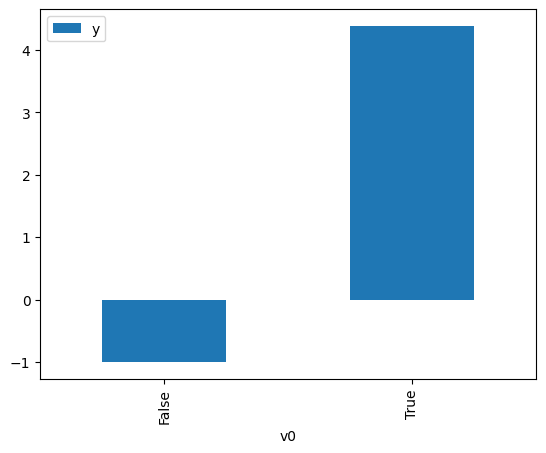

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

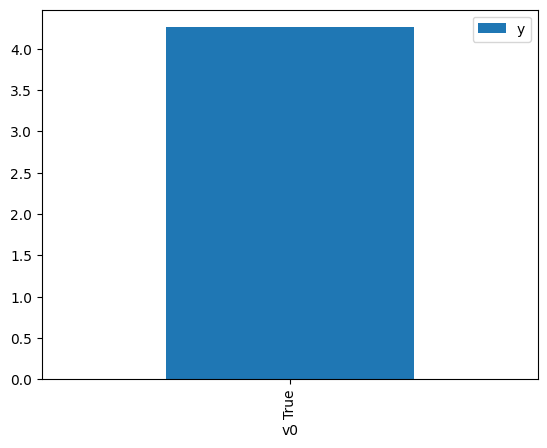

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.812883,False,1.200435,0.172278,5.804564
1,-0.300221,False,-1.210312,0.603445,1.657152
2,-0.609151,False,-1.009581,0.725514,1.378334
3,0.545766,False,2.260545,0.251212,3.980701
4,-1.796086,False,-2.784393,0.956617,1.045350
...,...,...,...,...,...
995,-0.703199,False,-0.793769,0.757692,1.319797
996,-0.048418,False,-0.936854,0.492451,2.030657
997,-2.623479,False,-3.076311,0.989770,1.010336
998,-0.209454,False,-0.110930,0.564050,1.772891


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.947176,True,5.324704,0.171346,5.836146
1,-0.131105,True,5.919088,0.470638,2.124777
2,-1.081580,True,3.988420,0.139875,7.149262
3,0.690915,True,5.513900,0.794387,1.258832
4,-0.291842,True,7.425734,0.400144,2.499101
...,...,...,...,...,...
995,-1.685624,True,3.390587,0.052356,19.100094
996,-2.166020,True,3.909257,0.022876,43.713333
997,-1.771122,True,2.892219,0.045273,22.088416
998,-1.103424,True,2.582233,0.135243,7.394089


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              4325.
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                        0.00
Time:                        22:07:20   Log-Likelihood:                         -1443.6
No. Observations:                1000   AIC:                                      2891.
Df Residuals:                     998   BIC:                                      2901.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0584      0.024     44.989      0.000       1.012       1.105
x2             5.0185      0.062     81.408      0.000       4.898       5.140
==============================================================================
Omnibus:                        3.020   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                2.942
Skew:                           0.093   Prob(JB):                        0.230
Kurtosis:                       2.811   Cond. No.                         2.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""